In [29]:
# PHASE 1: DATA LOADING & EXPLORATION


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix, ConfusionMatrixDisplay)
import xgboost as xgb
import kagglehub

# Download dataset
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")
print(f"Dataset path: {path}")

# Load data
df = pd.read_csv(f"{path}/WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(f"\nDataset shape: {df.shape}")

# Display first 5 rows
print("\nFirst 5 rows:")
df.head()

Using Colab cache for faster access to the 'ibm-hr-analytics-attrition-dataset' dataset.
Dataset path: /kaggle/input/ibm-hr-analytics-attrition-dataset

Dataset shape: (1470, 35)

First 5 rows:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [30]:
# Data quality checks
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

Missing values: 0
Duplicate rows: 0


In [31]:
# Check outcome variable
print("Attrition distribution:")
print(df['Attrition'].value_counts(normalize=True))

Attrition distribution:
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [32]:
# PHASE 2: PREPROCESSING & FEATURE ENGINEERING


# Encode target variable
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Create new features based on research question domains
df['IncomePerYear'] = df['MonthlyIncome'] / (df['YearsAtCompany'] + 1)
df['CareerVelocity'] = df['JobLevel'] / (df['YearsAtCompany'] + 1)
df['AvgSatisfaction'] = (df['JobSatisfaction'] +
                         df['EnvironmentSatisfaction'] +
                         df['RelationshipSatisfaction']) / 3

# One-hot encode categorical variables
cat_cols = ['OverTime', 'Department', 'JobRole', 'BusinessTravel', 'Gender', 'EducationField', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Prepare features and target
X = df_encoded.drop(['Attrition', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
y = df_encoded['Attrition']

print(f"Final features: {X.shape[1]}")
print(f"Target mean: {y.mean():.3f}")

Final features: 48
Target mean: 0.161


In [33]:
# PHASE 3: TRAIN-TEST SPLIT


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train attrition: {y_train.mean():.3f}, Test attrition: {y_test.mean():.3f}")

Train: 1176, Test: 294
Train attrition: 0.162, Test attrition: 0.160


In [34]:
# PHASE 4: MODEL 1 - RANDOM FOREST (BAGGING)


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Random Forest trained")

Random Forest trained


In [35]:
# PHASE 5: MODEL 2 - XGBOOST (GRADIENT BOOSTING)


xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5.2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='auc'
)

xgb_model.fit(X_train, y_train)
print("XGBoost trained")

XGBoost trained


In [36]:
# PHASE 6: CROSS-VALIDATION COMPARISON


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

rf_cv = cross_validate(rf_model, X_train, y_train, cv=cv, scoring=scoring)
xgb_cv = cross_validate(xgb_model, X_train, y_train, cv=cv, scoring=scoring)

# Results table
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    'RF_Mean': [rf_cv['test_accuracy'].mean(), rf_cv['test_precision'].mean(),
                rf_cv['test_recall'].mean(), rf_cv['test_f1'].mean(), rf_cv['test_roc_auc'].mean()],
    'XGB_Mean': [xgb_cv['test_accuracy'].mean(), xgb_cv['test_precision'].mean(),
                 xgb_cv['test_recall'].mean(), xgb_cv['test_f1'].mean(), xgb_cv['test_roc_auc'].mean()]
})

print(results.round(3))

      Metric  RF_Mean  XGB_Mean
0   Accuracy    0.862     0.870
1  Precision    0.642     0.656
2     Recall    0.337     0.416
3         F1    0.432     0.505
4    ROC-AUC    0.799     0.797


In [37]:
# PHASE 7: FINAL MODEL EVALUATION (XGBoost)


y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Final Model Performance (Test Set):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Final Model Performance (Test Set):
Accuracy: 0.827
Precision: 0.441
Recall: 0.319
F1: 0.370
ROC-AUC: 0.761

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       247
           1       0.44      0.32      0.37        47

    accuracy                           0.83       294
   macro avg       0.66      0.62      0.63       294
weighted avg       0.81      0.83      0.81       294



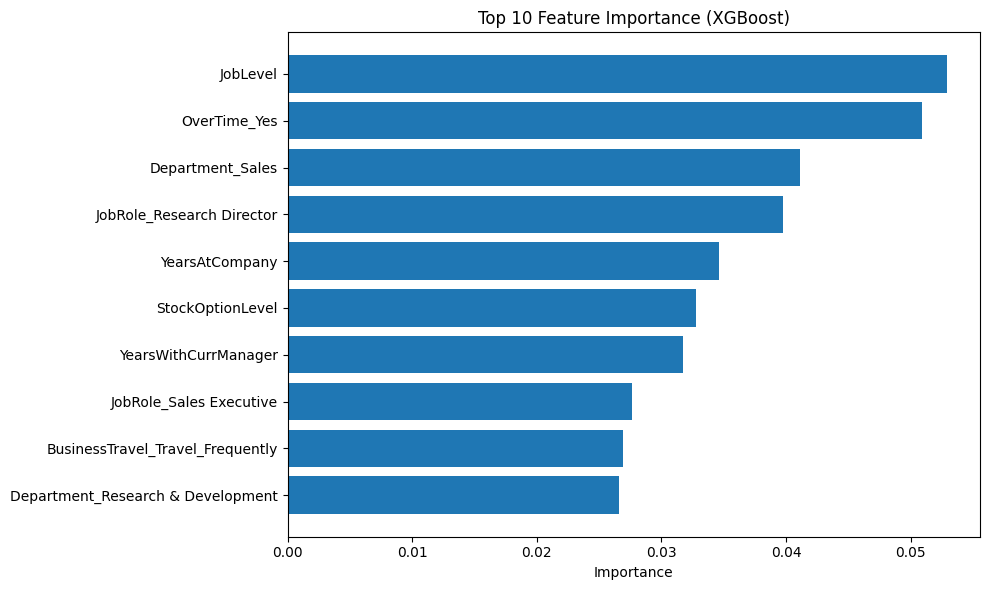

                              Feature  Importance
8                            JobLevel    0.052914
27                       OverTime_Yes    0.050912
29                   Department_Sales    0.041078
34          JobRole_Research Director    0.039775
20                     YearsAtCompany    0.034642
16                   StockOptionLevel    0.032774
23               YearsWithCurrManager    0.031735
36            JobRole_Sales Executive    0.027644
38   BusinessTravel_Travel_Frequently    0.026913
28  Department_Research & Development    0.026585


In [38]:
# PHASE 8: FEATURE IMPORTANCE


importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(importance)